In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, 
                             ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay)

## Знакомство с данными и их предобработка

In [2]:
# Чтение csv файла и формирование датафрейма.
path = os.path.join(os.getcwd(), 'asset-v1_SkillFactory+MIPTDS+SEPT22+type@asset+block@train.csv')
data = pd.read_csv(path, sep=',')
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# Информация о наименовании колонок, типах данных, используемой памяти, кол-ве строк и колонок, кол-во непустых 
# значений в колонке.
data.info()
# 12 колонок, 891 строка. 5 типов object, 7 типов numeric переменных. Есть пустые значения в колонках Age, Cabin, Embarked.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# ID of passenger (unique ID)
print(data['PassengerId'].nunique())
# Удаляем колонку с id, не содержит значимой информации.
data.drop(['PassengerId'], axis=1, inplace=True)

891


0    549
1    342
Name: Survived, dtype: int64


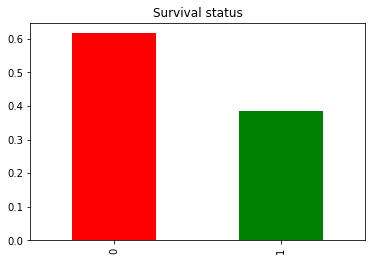

In [5]:
# Колонка Survived - Статус выживания (0 = No, 1 = Yes) - target column
# Количество и доля не выживших и выживших.
print(data['Survived'].value_counts())
data['Survived'].value_counts(True).plot(kind='bar', title='Survival status', color = ['r', 'g'])
plt.show()
# Присутствует дисбаланс классов (не выживших больше, чем выживших). 

In [6]:
# Колонка Pclass класс билета (1 = 1st/Upper, 2 = 2nd/Middle, 3 = 3rd/Lower)
print(data['Pclass'].value_counts())
data['Pclass'].value_counts(True)
# Чуть больше половины билетов 3-го класса (примерно 55%), остальные 45% поделили билеты между 1-м (24%) и 2-м (21%) классом.

3    491
1    216
2    184
Name: Pclass, dtype: int64


3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

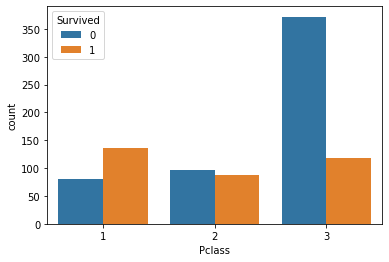

In [7]:
# Отобразим кол-во пассажиров по классу билета и статусу выживания на графике.
# Кол-во не выживших преобладает в 3-ем классе.
sns.countplot(data=data, x='Pclass', hue='Survived')
plt.show()

In [8]:
# Колонка Name Имя пассажира (уникальное)
data['Name'].nunique()

891

In [9]:
# Создадим колонку Group_name - обращение, из колонки Name
data['Group_name'] = data['Name'].str.split(pat=', ', n=1, expand=True)[1].str.split(pat='.', n=1, expand=True)[0]
data['Group_name'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
Don               1
Ms                1
Capt              1
the Countess      1
Sir               1
Mme               1
Jonkheer          1
Lady              1
Name: Group_name, dtype: int64

In [10]:
# Заменим редко встречающиеся обращения (не превышащие два, таких нашлось 11 шт.) на соответствующие или other
replace_dict = {'Mlle': 'Miss', 'Col': 'Other', 'Major': 'Other', 'Mme': 'Mrs', 'Jonkheer': 'Other', 'Ms': 'Miss',\
                'Capt': 'Other', 'Don': 'Mr', 'Sir': 'Mr', 'Lady': 'Mrs', 'the Countess': 'Mrs'}
data.replace({'Group_name': replace_dict}, inplace=True)

In [11]:
# В колонке Group_name нет пропущенных значений, обновились уникальные значения.
print(data['Group_name'].isnull().sum())
data['Group_name'].value_counts()

0


Mr        519
Miss      185
Mrs       128
Master     40
Dr          7
Rev         6
Other       6
Name: Group_name, dtype: int64

In [12]:
# Удаляем колонку Name, поскольку обращения из нее выделили.
data.drop(['Name'], axis=1, inplace=True)
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Group_name
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,211536,13.0000,NaN,S,Rev
887,1,1,female,19.0,0,0,112053,30.0000,B42,S,Miss
888,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss
889,1,1,male,26.0,0,0,111369,30.0000,C148,C,Mr


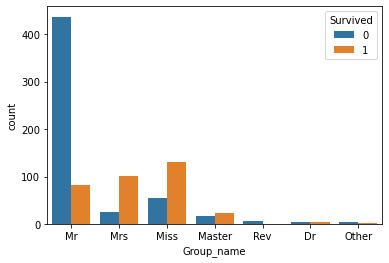

In [13]:
# Отобразим кол-во пассажиров по группе обращения(имя) и статусу выживания на графике.
sns.countplot(data=data, x='Group_name', hue='Survived')
plt.show()

In [14]:
# Колонка Sex пол пассажира (male или female)
print(data['Sex'].value_counts())
data['Sex'].value_counts(True)
# Преобладали пассажиры мужского пола (примерно 65%)

male      577
female    314
Name: Sex, dtype: int64


male      0.647587
female    0.352413
Name: Sex, dtype: float64

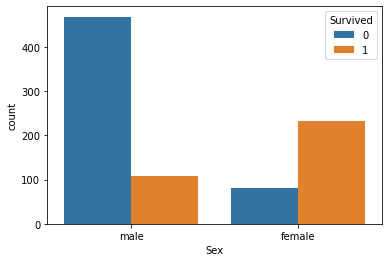

In [15]:
# Отобразим кол-во пассажиров по полу и статусу выживания на графике.
sns.countplot(data=data, x='Sex', hue='Survived')
plt.show()

In [16]:
# Колонка Age возраст пассажира (в годах)
# Уникальных значений 88 шт.
# Исходя из описательной статистики мин. возраст 5 месяцев, макс. возраст - 80, средний возраст - 29,7, медиана - 28.
print(data['Age'].value_counts())
data['Age'].describe()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [17]:
# Для заполнения пропущенных значений в колонке Age возьмем медианы по группам в колонке Group_name
unique_group_median = data.groupby('Group_name')['Age'].agg('median')
unique_group = data['Group_name'].unique()
for group in unique_group:
    data.loc[(data['Age'].isnull()) & (data['Group_name'] == group), 'Age'] = unique_group_median[group]

In [18]:
# Описательная статистика после заполнения пропущенных значений в колонке Age
data['Age'].describe()

count    891.000000
mean      29.390202
std       13.265322
min        0.420000
25%       21.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [19]:
# Разделяем на 4 бина по возрасту:
data['Age_bin'] = pd.qcut(data['Age'], 4)
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Group_name,Age_bin
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,"(21.0, 30.0]"
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,"(35.0, 80.0]"
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,"(21.0, 30.0]"
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,"(30.0, 35.0]"
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr,"(30.0, 35.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,211536,13.0000,NaN,S,Rev,"(21.0, 30.0]"
887,1,1,female,19.0,0,0,112053,30.0000,B42,S,Miss,"(0.419, 21.0]"
888,0,3,female,21.0,1,2,W./C. 6607,23.4500,NaN,S,Miss,"(0.419, 21.0]"
889,1,1,male,26.0,0,0,111369,30.0000,C148,C,Mr,"(21.0, 30.0]"


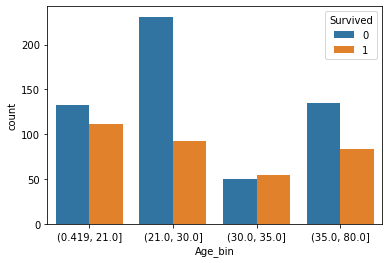

In [20]:
# Отобразим кол-во пассажиров по возрастной категории и статусу выживания на графике.
# Среди возрастных групп не выжившие преобладают в группе от 21 до 30 лет.
sns.countplot(data=data, x='Age_bin', hue='Survived')
plt.show()

In [21]:
# Колонка SibSp кол-во братьев и сестер/супругов на борту.
# Колонка Parch кол-во родителей/детей на борту.
# Объединим две колонки в одну Family - кол-во близких родственников на борту, помимо самого пассажира.
data['Family'] = data['SibSp'] + data['Parch']
data['Family'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family, dtype: int64

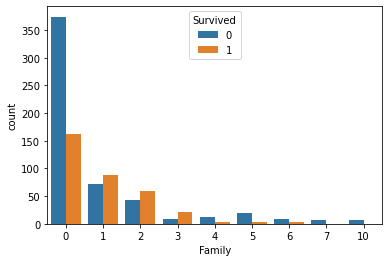

In [22]:
# Отобразим кол-во пассажиров по Family и статусу выживания на графике.
sns.countplot(data=data, x='Family', hue='Survived')
plt.show()

In [23]:
# Ticket номер билета (уникальный)
data['Ticket'].nunique()

681

In [24]:
# Группируем по кол-ву пассажиров на один билет. Выводим кол-во билетов на кол-во пассажиров на один билет.
unique_ticket = data.groupby('Ticket')['Ticket'].agg('count')
unique_ticket.value_counts()

1    547
2     94
3     21
4     11
7      3
6      3
5      2
Name: Ticket, dtype: int64

In [25]:
# Fare пассажирский тариф с описательной статистикой. Мин. значение оплаты за билет - 0, макс. значение - 512,3292.
# Среднее значение - примерно 32, медиана - примерно 14,5.
data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [26]:
# Разделяем на 5 бинов по размеру оплаты тарифа
data['Fare_bin'] = pd.qcut(data['Fare'], 5)
data['Fare_bin'].value_counts()

(7.854, 10.5]        184
(21.679, 39.688]     180
(-0.001, 7.854]      179
(39.688, 512.329]    176
(10.5, 21.679]       172
Name: Fare_bin, dtype: int64

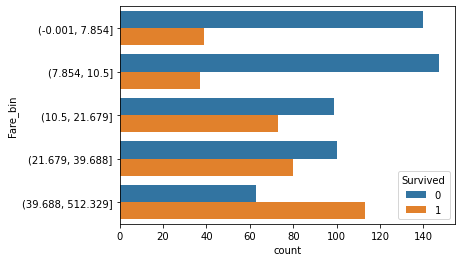

In [27]:
# Отобразим кол-во пассажиров по разбиениям тарифов и статусу выживания на графике.
sns.countplot(data=data, y='Fare_bin', hue='Survived')
plt.show()

In [28]:
# Cabin Номер каюты
# 77% данного признака не заполнены.
round(data['Cabin'].isnull().sum()/data.shape[0], 2)

0.77

In [29]:
# Кол-во пропущенных значений колонки Cabin
data['Cabin'].isnull().sum()

687

In [30]:
# Кол-во уникальных значений колонки Cabin
data['Cabin'].nunique()

147

In [31]:
# Embarked Порт посадки (C = Cherbourg, Q = Queenstown, S = Southampton), есть пропущенные значения, 
# наиболее встречающийся порт S, встречается 644 раза
data['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [32]:
# Заполним пропущенные значения колонки наиболее встречающимся значением
data.loc[data['Embarked'].isnull(), 'Embarked'] = data['Embarked'].mode()[0]
data['Embarked'].describe()

count     891
unique      3
top         S
freq      646
Name: Embarked, dtype: object

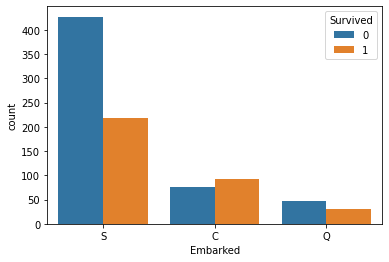

In [33]:
# Отобразим кол-во пассажиров по порту посадки и статусу выживания на графике.
sns.countplot(data=data, x='Embarked', hue='Survived')
plt.show()

In [34]:
# Удаляем колонки SibSp, Parch, Ticket, Fare, Cabin, Age
data.drop(['SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Age'], axis=1, inplace=True)
data

,Survived,Pclass,Sex,Embarked,Group_name,Age_bin,Family,Fare_bin
0,0,3,male,S,Mr,"(21.0, 30.0]",1,"(-0.001, 7.854]"
1,1,1,female,C,Mrs,"(35.0, 80.0]",1,"(39.688, 512.329]"
2,1,3,female,S,Miss,"(21.0, 30.0]",0,"(7.854, 10.5]"
3,1,1,female,S,Mrs,"(30.0, 35.0]",1,"(39.688, 512.329]"
4,0,3,male,S,Mr,"(30.0, 35.0]",0,"(7.854, 10.5]"
...,...,...,...,...,...,...,...,...
886,0,2,male,S,Rev,"(21.0, 30.0]",0,"(10.5, 21.679]"
887,1,1,female,S,Miss,"(0.419, 21.0]",0,"(21.679, 39.688]"
888,0,3,female,S,Miss,"(0.419, 21.0]",3,"(21.679, 39.688]"
889,1,1,male,C,Mr,"(21.0, 30.0]",0,"(21.679, 39.688]"


In [35]:
# Преобразование категорий в числовую форму
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])
data['Embarked'] = label_encoder.fit_transform(data['Embarked'])
data['Group_name'] = label_encoder.fit_transform(data['Group_name'])
data['Age_bin'] = label_encoder.fit_transform(data['Age_bin'])
data['Fare_bin'] = label_encoder.fit_transform(data['Fare_bin'])
data['Family'] = label_encoder.fit_transform(data['Family'])
data

,Survived,Pclass,Sex,Embarked,Group_name,Age_bin,Family,Fare_bin
0,0,3,1,2,3,1,1,0
1,1,1,0,0,4,3,1,4
2,1,3,0,2,2,1,0,1
3,1,1,0,2,4,2,1,4
4,0,3,1,2,3,2,0,1
...,...,...,...,...,...,...,...,...
886,0,2,1,2,6,1,0,2
887,1,1,0,2,2,0,0,3
888,0,3,0,2,2,0,3,3
889,1,1,1,0,3,1,0,3


In [36]:
# Запишем признаки в переменную X, целевой признак в переменную y.
X = data.drop('Survived', axis=1)
y = data['Survived']
# Разделим датафрейм на обучающую и тестовую выборки, задаем пропорцию классов при разделении на обучающий и проверяющий
# датасеты с помощью параметра stratify, чтобы учесть дисбаланс классов (статус выживания).
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=13)

In [37]:
#Инициализируем StandardScaler() для стандартизации количественных признаков и применим его на выборки.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[-0.40815611,  0.71984847,  0.58298434, ...,  1.49351569,
        -0.59659665, -0.70605703],
       [-1.62533594, -1.38918126, -1.9706782 , ..., -1.18359115,
         0.05459054,  1.42487413],
       [-1.62533594, -1.38918126, -1.9706782 , ...,  1.49351569,
        -0.59659665,  0.71456375],
       ...,
       [ 0.80902372,  0.71984847, -1.9706782 , ..., -0.2912222 ,
        -0.59659665, -1.41636742],
       [ 0.80902372, -1.38918126, -1.9706782 , ..., -0.2912222 ,
         0.70577774,  0.00425336],
       [ 0.80902372, -1.38918126,  0.58298434, ..., -0.2912222 ,
        -0.59659665, -1.41636742]])

## Обучение моделей и оценка качества

In [38]:
# Функция применения модели, подбор некоторых параметров и отображения оценки качества модели.
# Предположим, что важно меньшее кол-во предсказанных выживших, но на деле не выживших (FP).
# Обращаем внимание на метрики precision, roc_auc. Чем ближе к 1, тем лучше.
def model_display_metrics(model, X_train, y_train, X_test, y_test, param=None, model_params=None):
    if model_params is None:
        model_params = dict()
    print(model.__name__)
    model_ml = GridSearchCV(model(**model_params), param_grid=param, cv=10, n_jobs=-1, verbose=1, scoring='precision')
    model_ml.fit(X_train, y_train)
    best_estimator = model_ml.best_estimator_
    print(f'Best estimator for {model.__name__}:', best_estimator)
    best_score = model_ml.best_score_
    print(f'Best score for {model.__name__}:', best_score)
    best_params = model_ml.best_params_
    print(f'Params for {model.__name__}:', best_params)
    y_pred = model_ml.predict(X_test)
    
    fig = plt.figure(figsize=(14, 10))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    
    ConfusionMatrixDisplay.from_estimator(best_estimator, X_test, y_test, ax=ax1, cmap='GnBu')
    ax1.grid(False)
    ax1.set_title(f'Confusion Matrix for {model.__name__}')
    
    RocCurveDisplay.from_estimator(best_estimator, X_test, y_test, ax=ax2)
    ax2.set_title(f'Roc Curve for {model.__name__}')
    ax2.plot([0, 1], [0, 1], color="gray", linestyle="--")
    
    PrecisionRecallDisplay.from_estimator(best_estimator, X_test, y_test, ax=ax3)
    ax3.set_title(f'Precision Recal for {model.__name__}')
        
    plt.tight_layout()   
    plt.show()
    
    print(f'Classification Report:')
    print(classification_report(y_test, y_pred))
    
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    roc_auc = round(roc_auc_score(y_test, model_ml.predict_proba(X_test)[:, 1]), 3)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)
    print('ROC-AUC score:', roc_auc)
    
    return [accuracy, precision, recall, f1, roc_auc, best_estimator, best_params, best_score]

In [39]:
# Параметры для LogisticRegression 
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

LogisticRegression
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best estimator for LogisticRegression: LogisticRegression(C=0.01, random_state=42, solver='newton-cg')
Best score for LogisticRegression: 0.8287577330183167
Params for LogisticRegression: {'C': 0.01, 'solver': 'newton-cg'}


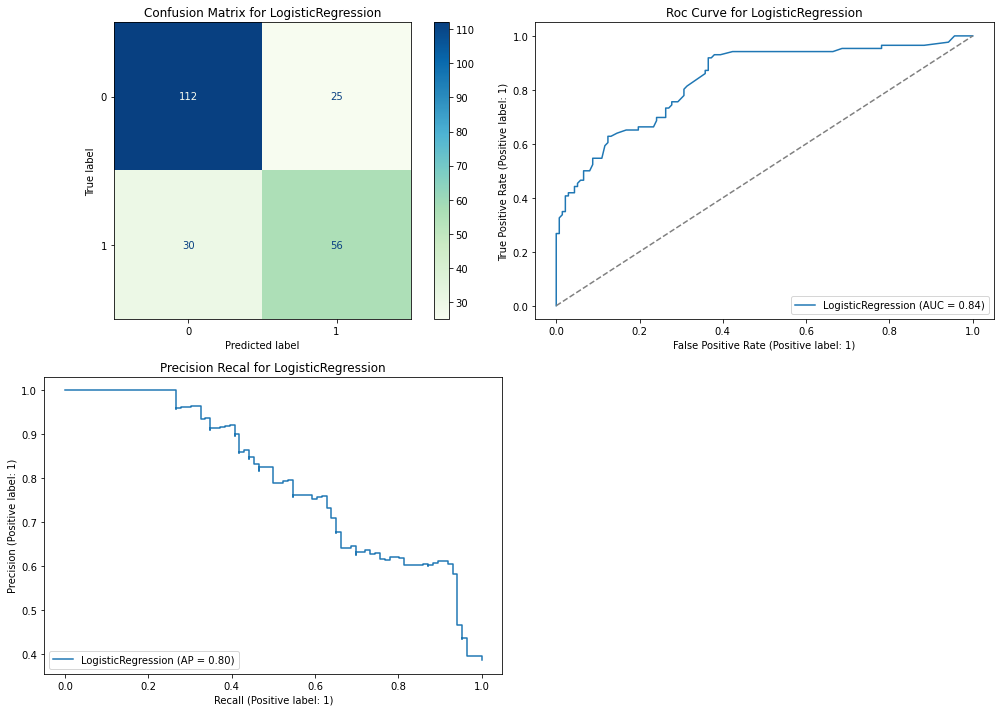

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       137
           1       0.69      0.65      0.67        86

    accuracy                           0.75       223
   macro avg       0.74      0.73      0.74       223
weighted avg       0.75      0.75      0.75       223

Accuracy: 0.753
Precision: 0.691
Recall: 0.651
F1-score: 0.671
ROC-AUC score: 0.837


In [40]:
# Logistic Regression
parameter_LR = {'C': [0.01, 0.03, 0.05],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
metrics_LR = model_display_metrics(LogisticRegression, X_train, y_train, X_test, y_test, param=parameter_LR,
                                  model_params=dict(random_state=42))

In [41]:
# Параметры для GaussianNB
GaussianNB().get_params().keys()

dict_keys(['priors', 'var_smoothing'])

GaussianNB
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best estimator for GaussianNB: GaussianNB(var_smoothing=1.0)
Best score for GaussianNB: 0.8547378769321494
Params for GaussianNB: {'var_smoothing': 1.0}


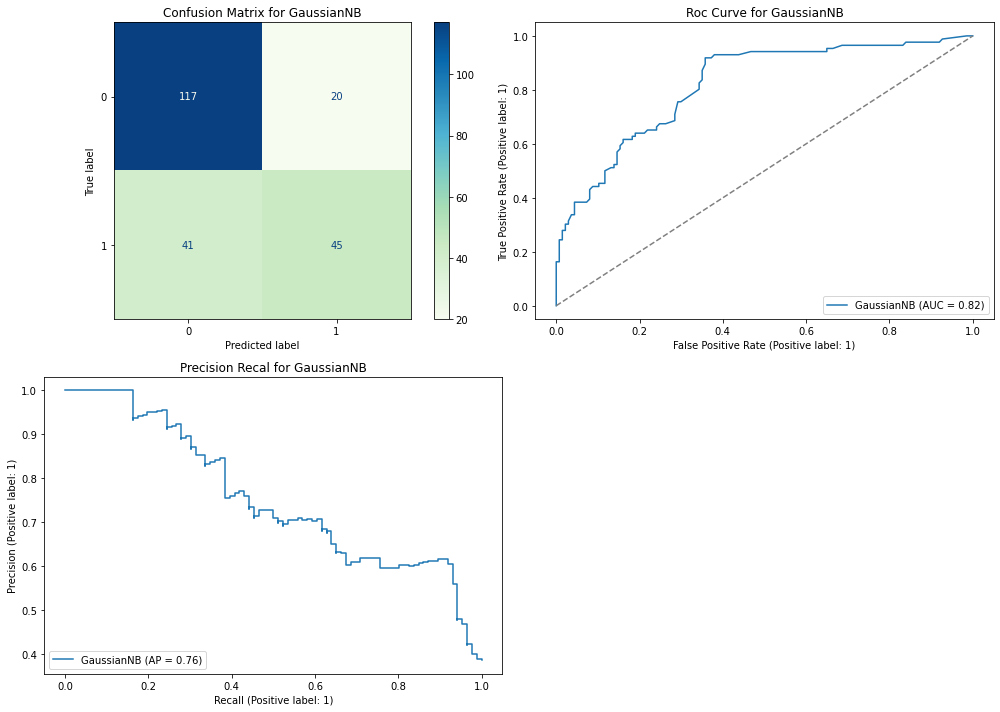

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       137
           1       0.69      0.52      0.60        86

    accuracy                           0.73       223
   macro avg       0.72      0.69      0.69       223
weighted avg       0.72      0.73      0.72       223

Accuracy: 0.726
Precision: 0.692
Recall: 0.523
F1-score: 0.596
ROC-AUC score: 0.819


In [42]:
# Gaussian Naive Bayes classifier
parameter_GNB = {'var_smoothing': np.logspace(0,-9, num=100)}
metrics_GNB = model_display_metrics(GaussianNB, X_train, y_train, X_test, y_test, param=parameter_GNB)

In [43]:
# Параметры для KNeighborsClassifier
KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

KNeighborsClassifier
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best estimator for KNeighborsClassifier: KNeighborsClassifier(n_jobs=-1, n_neighbors=4)
Best score for KNeighborsClassifier: 0.8571019404572036
Params for KNeighborsClassifier: {'n_neighbors': 4}


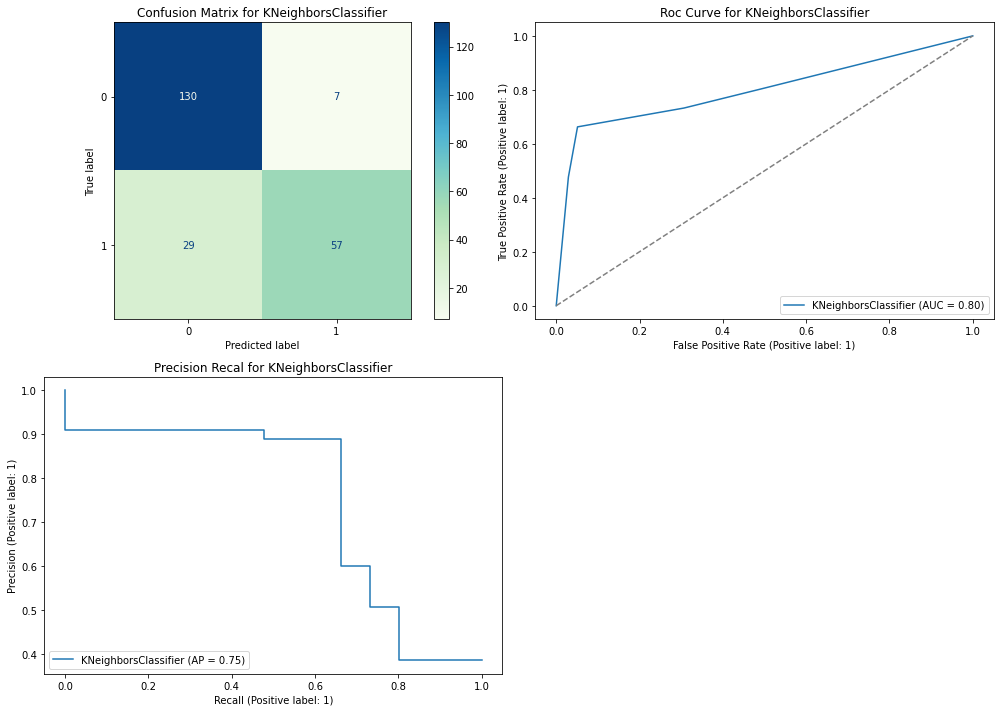

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       137
           1       0.89      0.66      0.76        86

    accuracy                           0.84       223
   macro avg       0.85      0.81      0.82       223
weighted avg       0.85      0.84      0.83       223

Accuracy: 0.839
Precision: 0.891
Recall: 0.663
F1-score: 0.76
ROC-AUC score: 0.798


In [44]:
# K-Nearest neighbors classifier
parameter_KNN = {'n_neighbors': range(2, 11)}
metrics_KNN = model_display_metrics(KNeighborsClassifier, X_train, y_train, X_test, y_test, param=parameter_KNN, 
                                    model_params=dict(n_jobs=-1))

In [45]:
# Параметры для SVC
SVC().get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

SVC
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best estimator for SVC: SVC(C=0.30000000000000004, probability=True, random_state=1)
Best score for SVC: 0.8140152721674461
Params for SVC: {'C': 0.30000000000000004, 'kernel': 'rbf'}


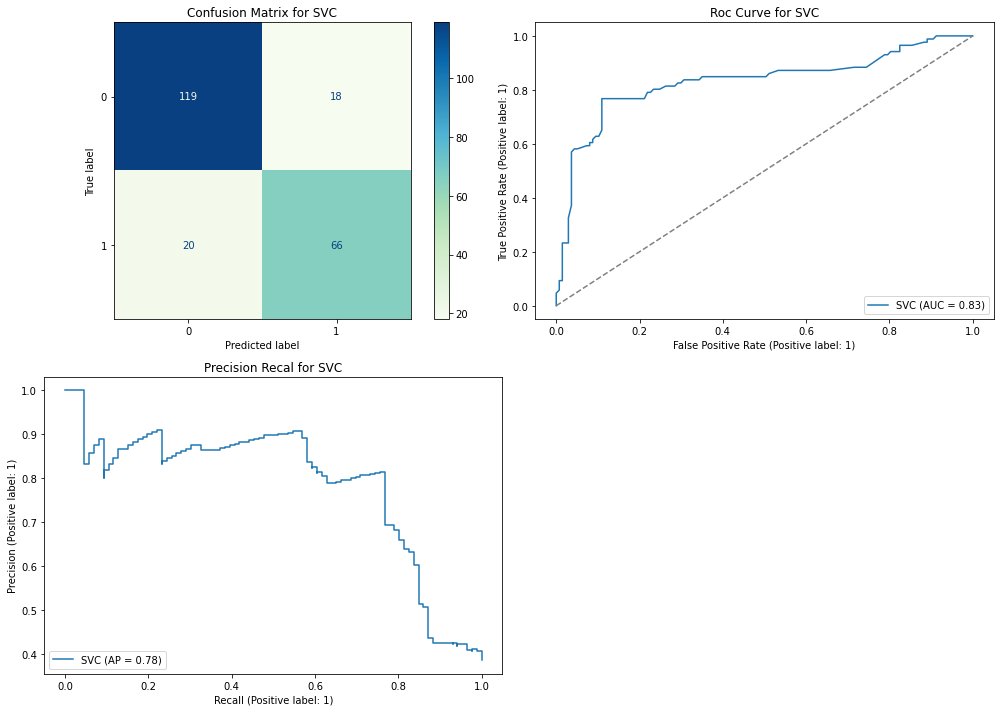

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       137
           1       0.79      0.77      0.78        86

    accuracy                           0.83       223
   macro avg       0.82      0.82      0.82       223
weighted avg       0.83      0.83      0.83       223

Accuracy: 0.83
Precision: 0.786
Recall: 0.767
F1-score: 0.776
ROC-AUC score: 0.83


In [46]:
# Support Vector Classifier
parameter_SVC = { 'C': np.arange(0.1, 0.5, 0.1),
                'kernel': ['linear', 'rbf', 'sigmoid']}
metrics_SVC = model_display_metrics(SVC, X_train, y_train, X_test, y_test, param=parameter_SVC,
                                    model_params=dict(random_state=1, probability=True))

In [47]:
# Таблица модели - метрики с указанием подобранных параметров (сортировка по колонке precision, по убыванию). 
pd.options.display.max_colwidth = 150
metrics_common = [metrics_LR, metrics_GNB, metrics_KNN, metrics_SVC]
data_metrics = pd.DataFrame(data=metrics_common, 
                            columns=['accuracy', 'precision', 'recall', 'f1-score', 'roc_auc', 'best_estimator', \
                                     'best_params', 'best_score'],
                            index=['LogisticRegression', 'GaussianNB', 'KNeighborsClassifier', 'SVC'])
data_metrics.sort_values(by='precision', ascending=False)

,accuracy,precision,recall,f1-score,roc_auc,best_estimator,best_params,best_score
KNeighborsClassifier,0.839,0.891,0.663,0.760,0.798,"KNeighborsClassifier(n_jobs=-1, n_neighbors=4)",{'n_neighbors': 4},0.857102
SVC,0.830,0.786,0.767,0.776,0.830,"SVC(C=0.30000000000000004, probability=True, random_state=1)","{'C': 0.30000000000000004, 'kernel': 'rbf'}",0.814015
GaussianNB,0.726,0.692,0.523,0.596,0.819,GaussianNB(var_smoothing=1.0),{'var_smoothing': 1.0},0.854738
LogisticRegression,0.753,0.691,0.651,0.671,0.837,"LogisticRegression(C=0.01, random_state=42, solver='newton-cg')","{'C': 0.01, 'solver': 'newton-cg'}",0.828758
